In [1]:
# see more styles and js code (linked at the bottom) at https://www.tylerxhobbs.com/words/flow-fields

In [2]:
from vfield import plot_vector_field, render_lic, render_flow_field
import torch
import matplotlib.pyplot as plt

vfield = torch.load('data/vectorfield.pt')

grid = vfield['grid']
displacement=vfield['displacement']

In [3]:
# LIC
lic_img = render_lic(grid, displacement, resolution=512, length=30, normalize=True)

# flow field
ff_img = render_flow_field(grid, displacement, W=1000, H=1000, N_PART=2000, extent=(-10, 10, -10, 10))

generate lics: 100%|██████████| 15/15 [00:01<00:00,  8.02it/s]


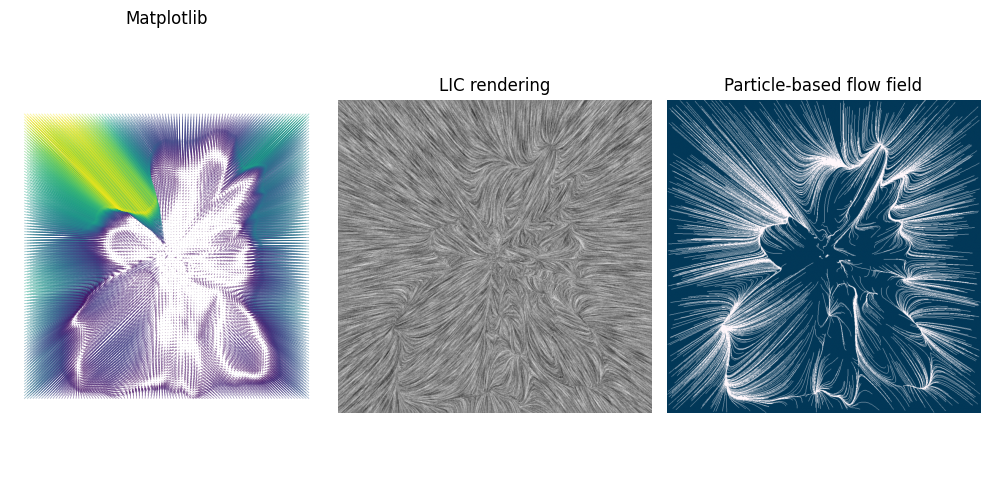

In [4]:
plt.figure(figsize=(10, 5))

plt.subplot(131)
plot_vector_field(grid, displacement)
plt.title('Matplotlib')
plt.axis('off')

plt.subplot(132)
plt.imshow(lic_img, cmap='gray', origin='lower')
plt.title(f'LIC rendering')
plt.axis('off')

plt.subplot(133)
plt.imshow(ff_img, cmap='PuBu', origin='lower')
plt.title('Particle-based flow field')
plt.axis('off')

plt.tight_layout()
plt.show()